In [1]:
# !python3 --version

In [2]:
from src.main.python.embedding.bert_embedding import BertEmbedding
# from src.main.python.preprocess.document_vectorizer import DocumentVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import hnswlib
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
bert = BertEmbedding()

In [4]:
bert.run(dataset_path="/home/felipeviegas/Codes_phd/cluwords_arc/fasttext_wiki/datasets/aisopos_ntua/d_train_data_0.txt",
         path_to_save_model="notebooks/data",
         fold=0,
         type="mean"
        )

Number of layers: 13, (initial embeddings + 12 BERT layers)
Number of batches: 222
Number of tokens: 128
Number of hidden units: 768
Tensor shape for each layer: torch.Size([222, 128, 768])
Token Embeddings: torch.Size([222, 128, 13, 768])


In [5]:
word_vectors, vocabulary_embedding = bert.get_word_vectors()

In [6]:
vocabulary_embedding.shape, word_vectors.shape

((1478,), (1478, 768))

In [7]:
t_sentences = bert.set_tokenize_sentences("/home/felipeviegas/Codes_phd/cluwords_arc/fasttext_wiki/datasets/aisopos_ntua/d_train_data_0.txt")

In [8]:
t_sentences[0]

'[CLS] feel dark eye rings getting darker darker mean processing right ar ##gh sad [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [9]:
vectorizer = CountVectorizer(analyzer='word', vocabulary=vocabulary_embedding, lowercase = False, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')

In [10]:
vectorizer.fit(t_sentences)

CountVectorizer(lowercase=False,
                token_pattern='[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+',
                vocabulary=array(['feel', 'dark', 'eye', ..., '##aj', '##ovo', '##vich'],
      dtype='<U13'))

In [11]:
# sentence_test = "I feel dark eye"

train = vectorizer.transform(t_sentences)
# train = vectorizer.transform([sentence_test])

dense_train = train.toarray()

text = ""
for term in range(0, dense_train[0].shape[0]):
    if dense_train[0][term] != 0:
        text += vocabulary_embedding[term] + " "

text.strip()

'feel dark eye rings getting darker mean processing right ar ##gh sad'

## hnswlib

In [12]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = word_vectors.shape[1]) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = vocabulary_embedding.shape[0], ef_construction = 200, M = 32)

In [13]:
word_vectors_labels = np.arange(vocabulary_embedding.shape[0])
# Element insertion (can be called several times):
p.add_items(word_vectors, word_vectors_labels)

# Controlling the recall by setting ef:
p.set_ef(600) # ef should always be > k

In [14]:
# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(word_vectors, k = 500)

In [15]:
cosine_matrix = 1. - distances

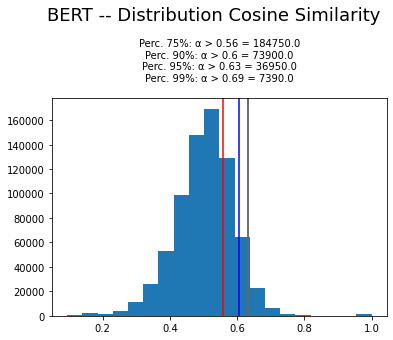

In [115]:
cosine_vec = cosine_matrix.flatten()
plt.figure()
_ = plt.hist(cosine_vec, bins=20)
title_string = "BERT -- Distribution Cosine Similarity"
subtitle_string = f"Perc. 75%: α > {np.round_(np.percentile(cosine_vec, 75), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 75)) * 1.)}\n" \
                  f"Perc. 90%: α > {np.round_(np.percentile(cosine_vec, 90), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 90)) * 1.)}\n" \
                  f"Perc. 95%: α > {np.round_(np.percentile(cosine_vec, 95), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 95)) * 1.)}\n" \
                  f"Perc. 99%: α > {np.round_(np.percentile(cosine_vec, 99), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 99)) * 1.)}\n"


plt.suptitle(title_string, y=1.2, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.axvline(np.percentile(cosine_vec, 75), color='red')
plt.axvline(np.percentile(cosine_vec, 90), color='blue')
plt.axvline(np.percentile(cosine_vec, 95), color='black')
plt.axvline(np.percentile(cosine_vec, 95), color='gray')

plt.show()

In [117]:
def retrive_top_similar_words(query):
    index = np.argwhere(vocabulary_embedding == query).flatten()
    if index.shape[0] > 0:
        neighbors = labels[index].flatten()
        neigh_labels = vocabulary_embedding[neighbors[:11]]
        neigh_sim = distances[index].flatten()
        return [f"({neigh_labels[idx]}, {np.round_(1. - neigh_sim[idx], 2)})" for idx in range(neigh_labels.shape[0])]
    
    return ""


In [118]:
",".join(retrive_top_similar_words("happy"))

'(happy, 1.0),(sad, 0.85),(laughing, 0.83),(love, 0.79),(offers, 0.77),(friends, 0.76),(goal, 0.76),(imagine, 0.75),(pants, 0.75),(amazing, 0.74),(poster, 0.74)'

In [119]:
",".join(retrive_top_similar_words("sad"))

'(sad, 1.0),(happy, 0.85),(laughing, 0.8),(poster, 0.77),(offers, 0.77),(quit, 0.76),(pants, 0.76),(impression, 0.76),(imagine, 0.75),(asleep, 0.75),(feeling, 0.75)'

In [120]:
",".join(retrive_top_similar_words("great"))

'(great, 1.0),(good, 0.82),(nice, 0.78),(beautiful, 0.77),(fantastic, 0.75),(big, 0.75),(awesome, 0.74),(wonderful, 0.73),(lovely, 0.73),(interesting, 0.73),(##able, 0.72)'

In [121]:
",".join(retrive_top_similar_words("dark"))

'(dark, 1.0),(darker, 0.76),(angry, 0.61),(nice, 0.61),(shitty, 0.61),(funny, 0.6),(watch, 0.6),(tough, 0.6),(rings, 0.6),(bad, 0.6),(said, 0.6)'